# ARIMA Forecasting

AutoRegressive Integrated Moving Average with eXogenous regressors model. Just remember that it is composed of several statistical models and is highly configurable.

ARIMA has an order=(p,d,q) parameter that manages the AR and MA parts of the algorithm. 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html?highlight=arima

SARIMAX is an extension of ARIMA that enables seasonal_order(P,D,Q,s) allowing for day, week, ... components.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

The practice is to run this algorithm for one unknown future date and use that date in the forcasting of next unknown dates.

Links and material (with examples).  
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/  
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/  
https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

https://towardsdatascience.com/anomaly-detection-def662294a4e  
https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://www.machinelearningplus.com/time-series/time-series-analysis-python/  

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q  
https://towardsdatascience.com/unboxing-arima-models-1dc09d2746f8

Official Documentation Statsmodel.  
https://www.statsmodels.org/dev/examples/index.html#time-series-analysis

**Important parameters considerations**  

- p: The number of lag observations included in the model, also called the lag order.

**p = the number of autoregressive terms**  
p is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

- d: The number of times that the raw observations are differenced, also called the degree of differencing.

**d = the number of nonseasonal differences**  
d is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

- q: The size of the moving average window, also called the order of moving average.

**q = the number of moving-average terms**.  
q is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

So in ARIMA we have (p,d,q).  
p is also called AR(p).  
q is also called MA(q).  
And togheter forms the ARMA(p,q), adding d become ARIMA(p,d,q) and stagionality s: SARIMA(s,p,d,q)  

How to find better parameters: 
https://towardsdatascience.com/unboxing-arima-models-1dc09d2746f8

### Dataset
The data on which the algorithms will be trained and tested upon comes from Kaggle Hourly Energy Consumption database. It is collected by PJM Interconnection, a company coordinating the continuous buying, selling, and delivery of wholesale electricity through the Energy Market from suppliers to customers in the reagon of South Carolina, USA. All .csv files contains rows with a timestamp and a value. The name of the value column corresponds to the name of the contractor. the timestamp represents a single hour and the value represents the total energy, cunsumed during that hour.

https://www.kaggle.com/robikscube/hourly-energy-consumption



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [2]:
plt.style.use('fivethirtyeight')
print(os.listdir("./data/hourly-energy-consumption"))

['est_hourly.paruqet', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


In [3]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [4]:
energy_hourly = pd.read_csv('./data/hourly-energy-consumption/PJME_hourly.csv', 
                            index_col=[0], parse_dates=[0])
energy_hourly.sort_index(inplace=True)
print("Shape:",energy_hourly.shape)
print(energy_hourly.columns)

Shape: (145366, 1)
Index(['PJME_MW'], dtype='object')


In [5]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,8), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

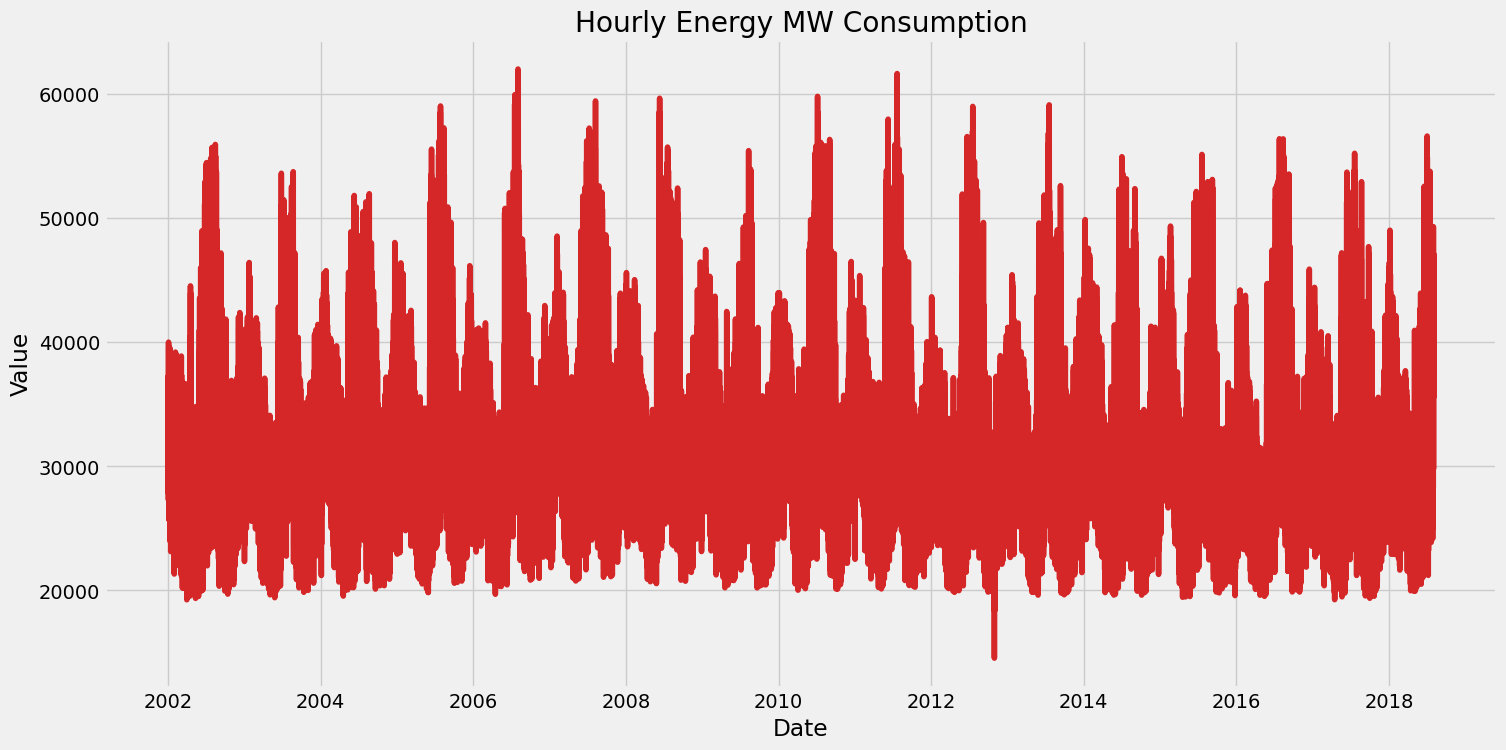

In [6]:
plot_df(energy_hourly, x=energy_hourly.index, y=energy_hourly.PJME_MW, title='Hourly Energy MW Consumption')

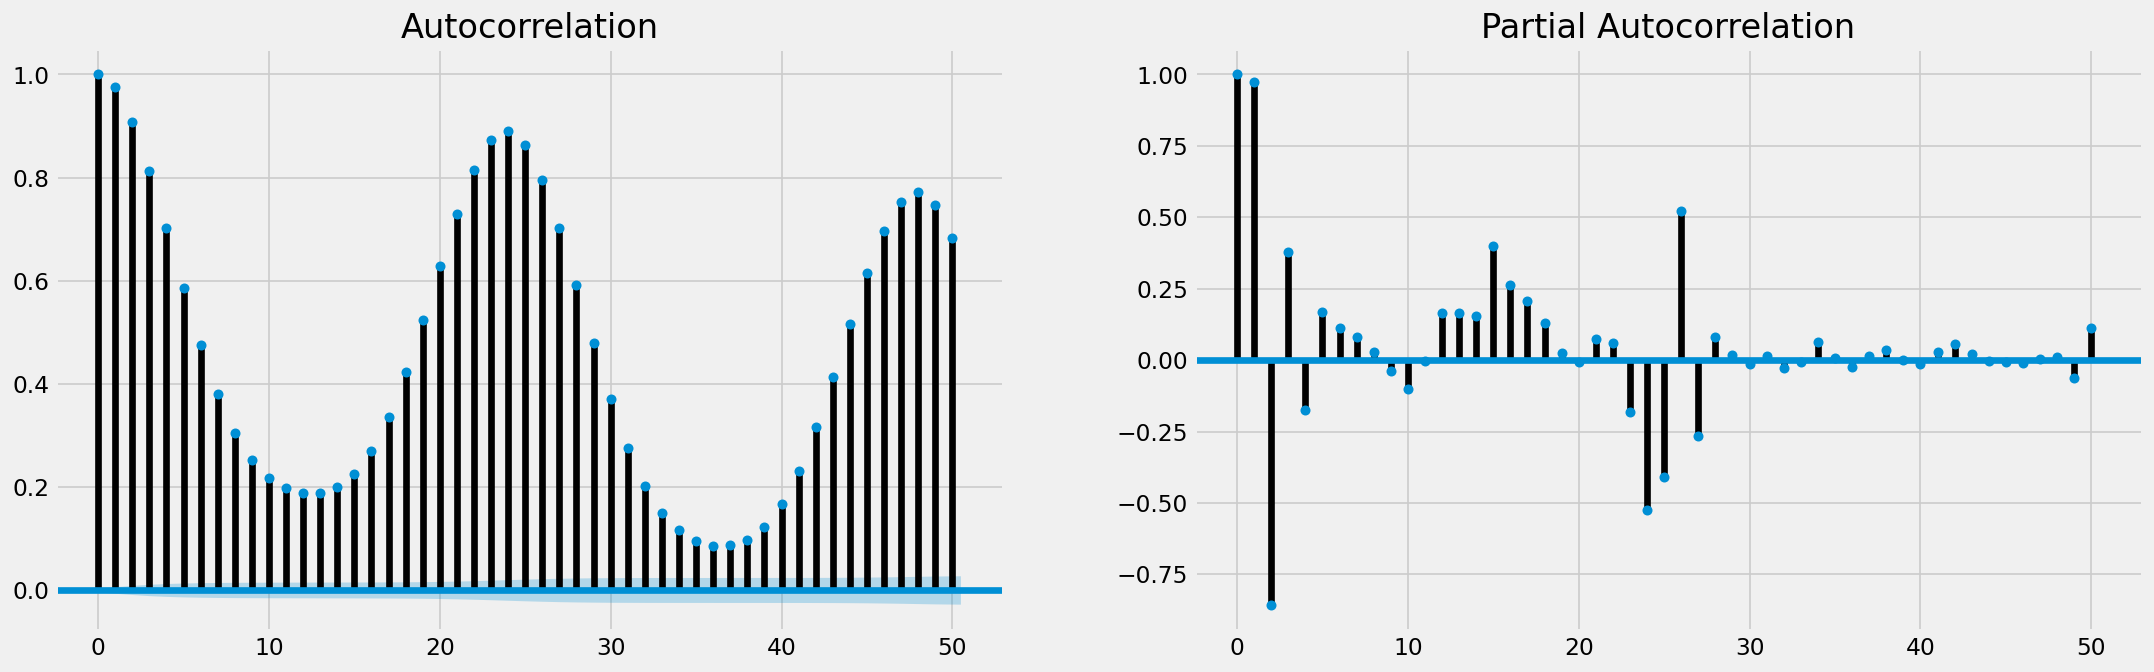

In [7]:
#AUTOCORRELATION
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
plot_acf(energy_hourly.PJME_MW.tolist(), lags=50, ax=axes[0])
plot_pacf(energy_hourly.PJME_MW.tolist(), lags=50, ax=axes[1])
plt.show()

### Series decomposition

In [8]:
from pylab import rcParams
import statsmodels.api as sm

/Users/jeydi/opt/anaconda3/envs/datalab/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/jeydi/opt/anaconda3/envs/datalab/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/jeydi/opt/anaconda3/envs/datalab/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/jeydi/opt/anacon

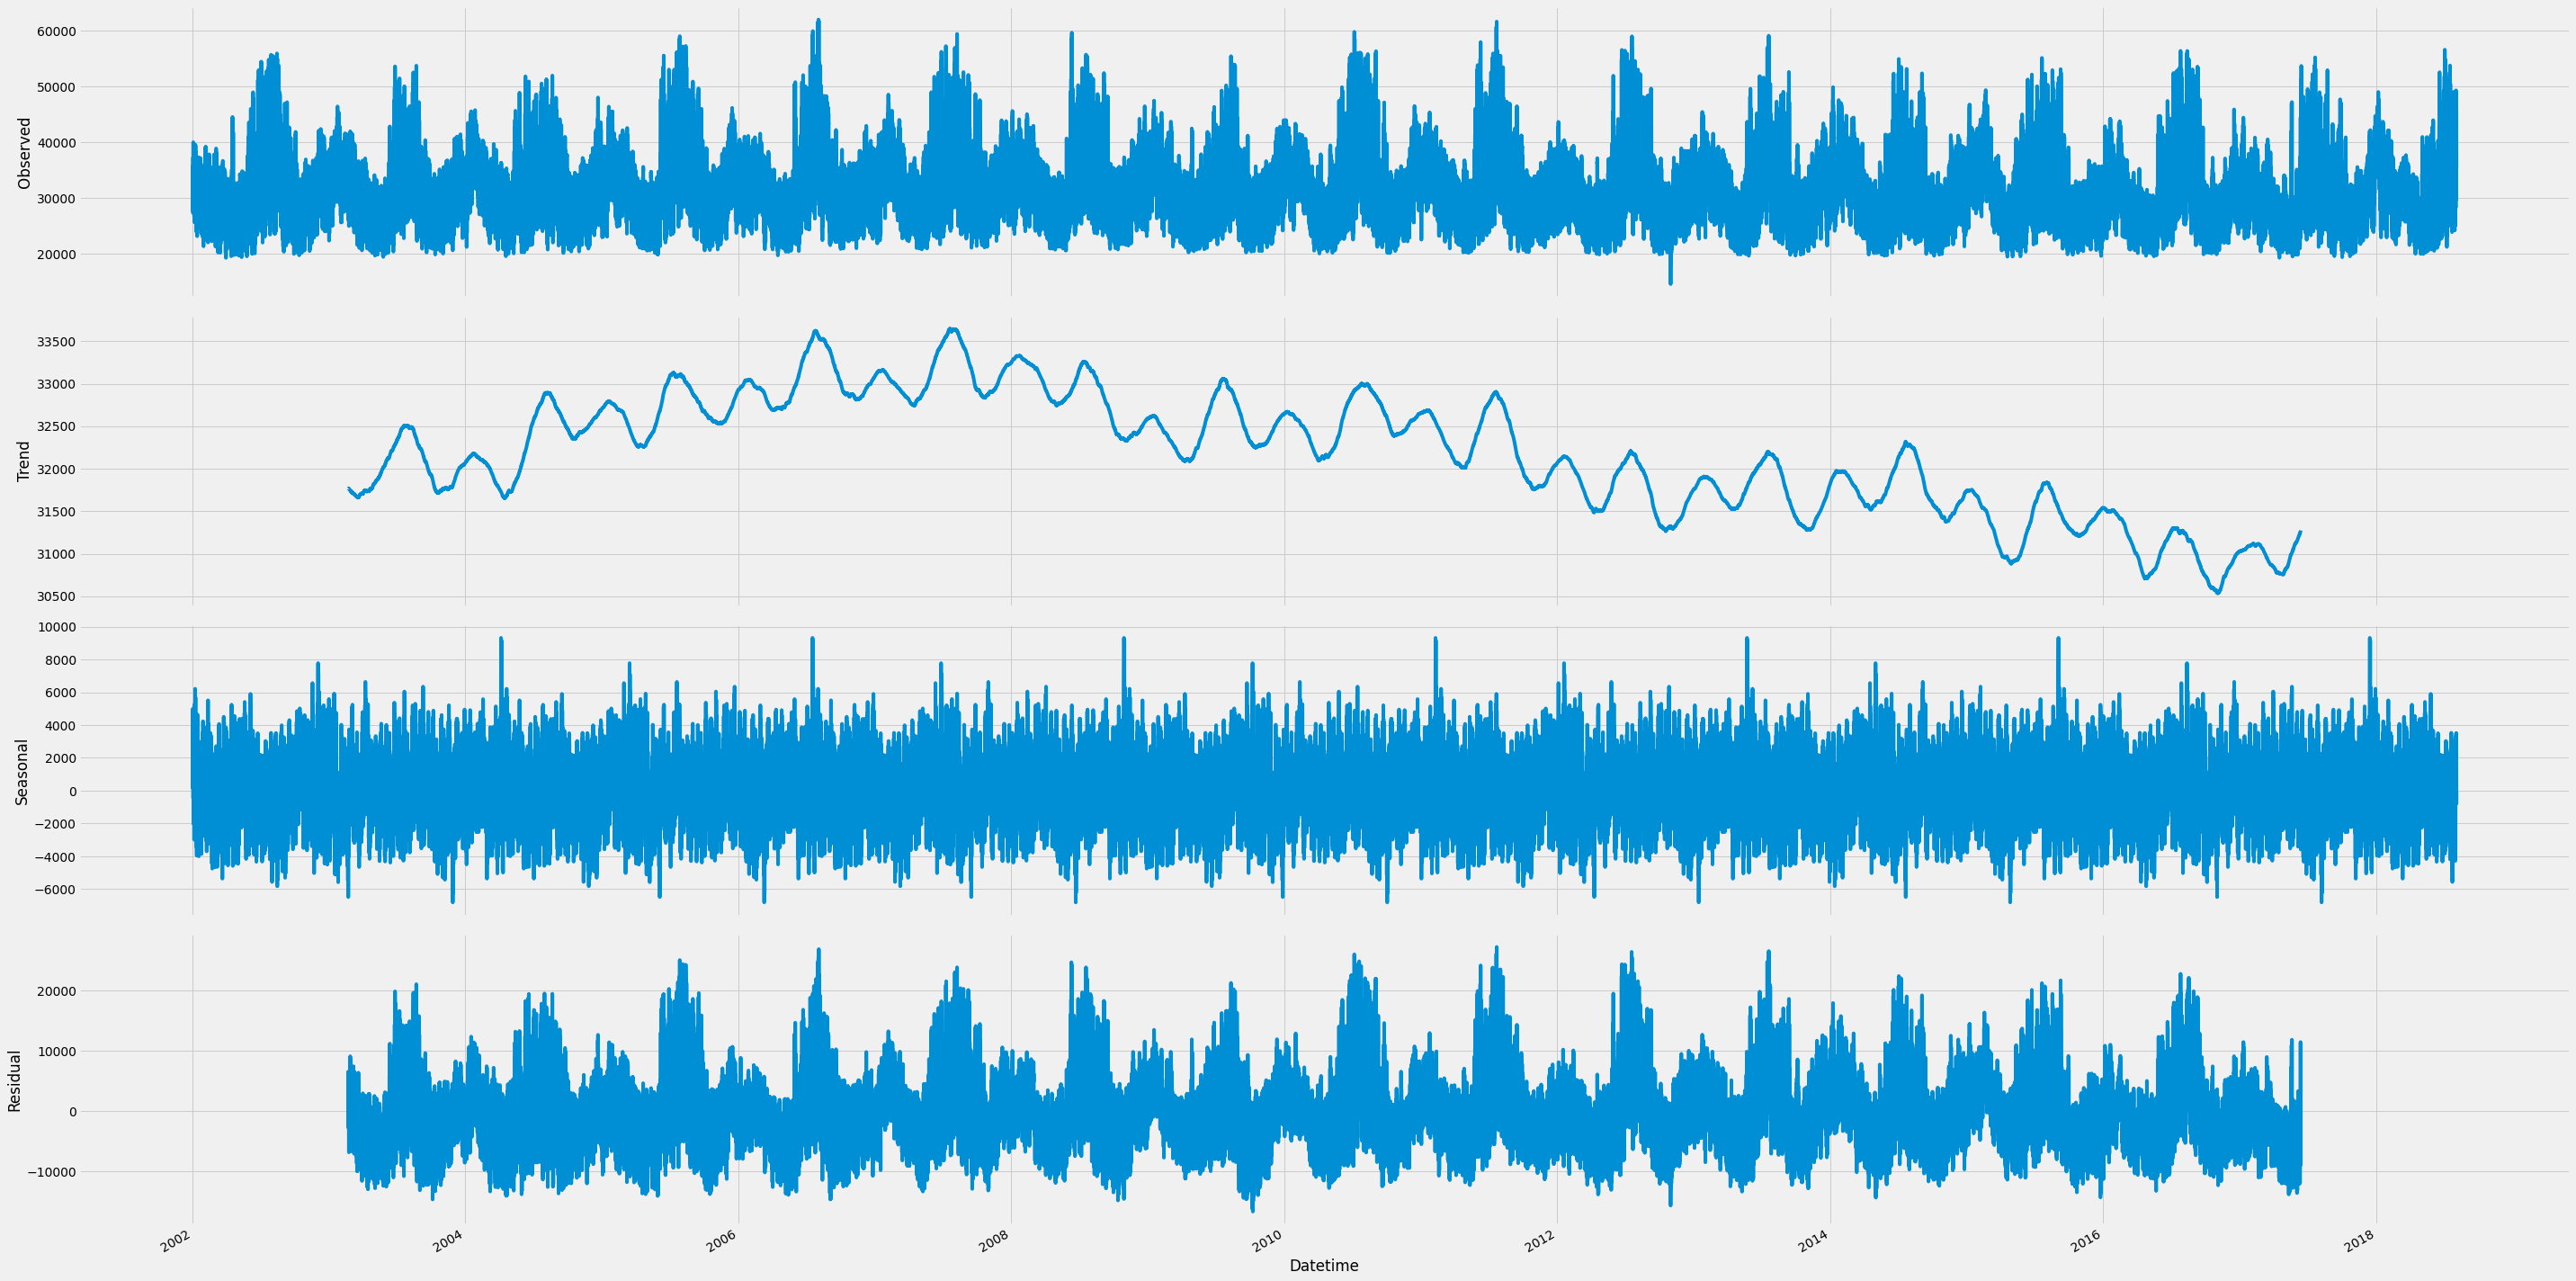

In [9]:
#Decompose the serie
rcParams['figure.figsize'] = 40, 20
decomposition = sm.tsa.seasonal_decompose(energy_hourly, model='additive',freq=20000)
fig = decomposition.plot()
plt.show()

### Feature engineering

In [10]:
t = energy_hourly.PJME_MW.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='H')
constructed = pd.Series(index=freq_index, name='PJME_MW')
constructed.update(t)
constructed.interpolate(inplace=True)
train, test = split_data(constructed, '01-Jul-2002')

train = limit(constructed, '03-01-2011', '04-01-2011')
test  = limit(constructed, '04-01-2011', '05-01-2011')

## ARIMA Model

Auto Arima Configuration

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

Remember to install pmdarima: pip install pmdarima

Documentation: http://alkaline-ml.com/pmdarima/about.html#about

In [13]:
from pyramid.arima import auto_arima

stepwise_model = auto_arima(energy_hourly, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2265820.259, BIC=2265869.694, Fit time=702.568 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2656566.214, BIC=2656585.988, Fit time=12.736 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2143621.047, BIC=2143660.595, Fit time=437.632 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2340804.215, BIC=2340843.762, Fit time=559.291 seconds


KeyboardInterrupt: 

In [ ]:
stepwise_model.fit(train)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=30)

#### Evaluate the model

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).iplot()

In [ ]:
pd.concat([data,future_forecast],axis=1).iplot()

### Custom SARIMAX Model

First let's try to apply SARIMA algorithm for forecasting. SARIMA stands for Seasonal Auto Regressive Integrated Moving Average. It has a seasonal parameter which we initialize as 7 due to weekly seasonality of our sales data. Other parameters are p,d,q which are identified based on ACF and PACF plots or ideally we should use the parameters with minimal error in forecasting.

More details can be found here: https://people.duke.edu/~rnau/arimrule.htm

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure).

- Null Hypothesis (H0): if failed to be rejected (high p-value) means it is non-stationary
- Null Hypothesis (H1): if H0 is rejected (low p-value) means it is stationary

In [11]:
model_A = sm.tsa.statespace.SARIMAX(constructed,
                                order=(1,1,1),
                                seasonal_order=(0,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_A = model_A.fit()
print('AIC =', results_A.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
forecast_A = results_A.forecast(steps=test.shape[0])

AIC = 2320356.2389879012


In [59]:
result = pd.DataFrame()
result['Actual'] = test
result['Forecast'] = forecast_A.values.tolist()

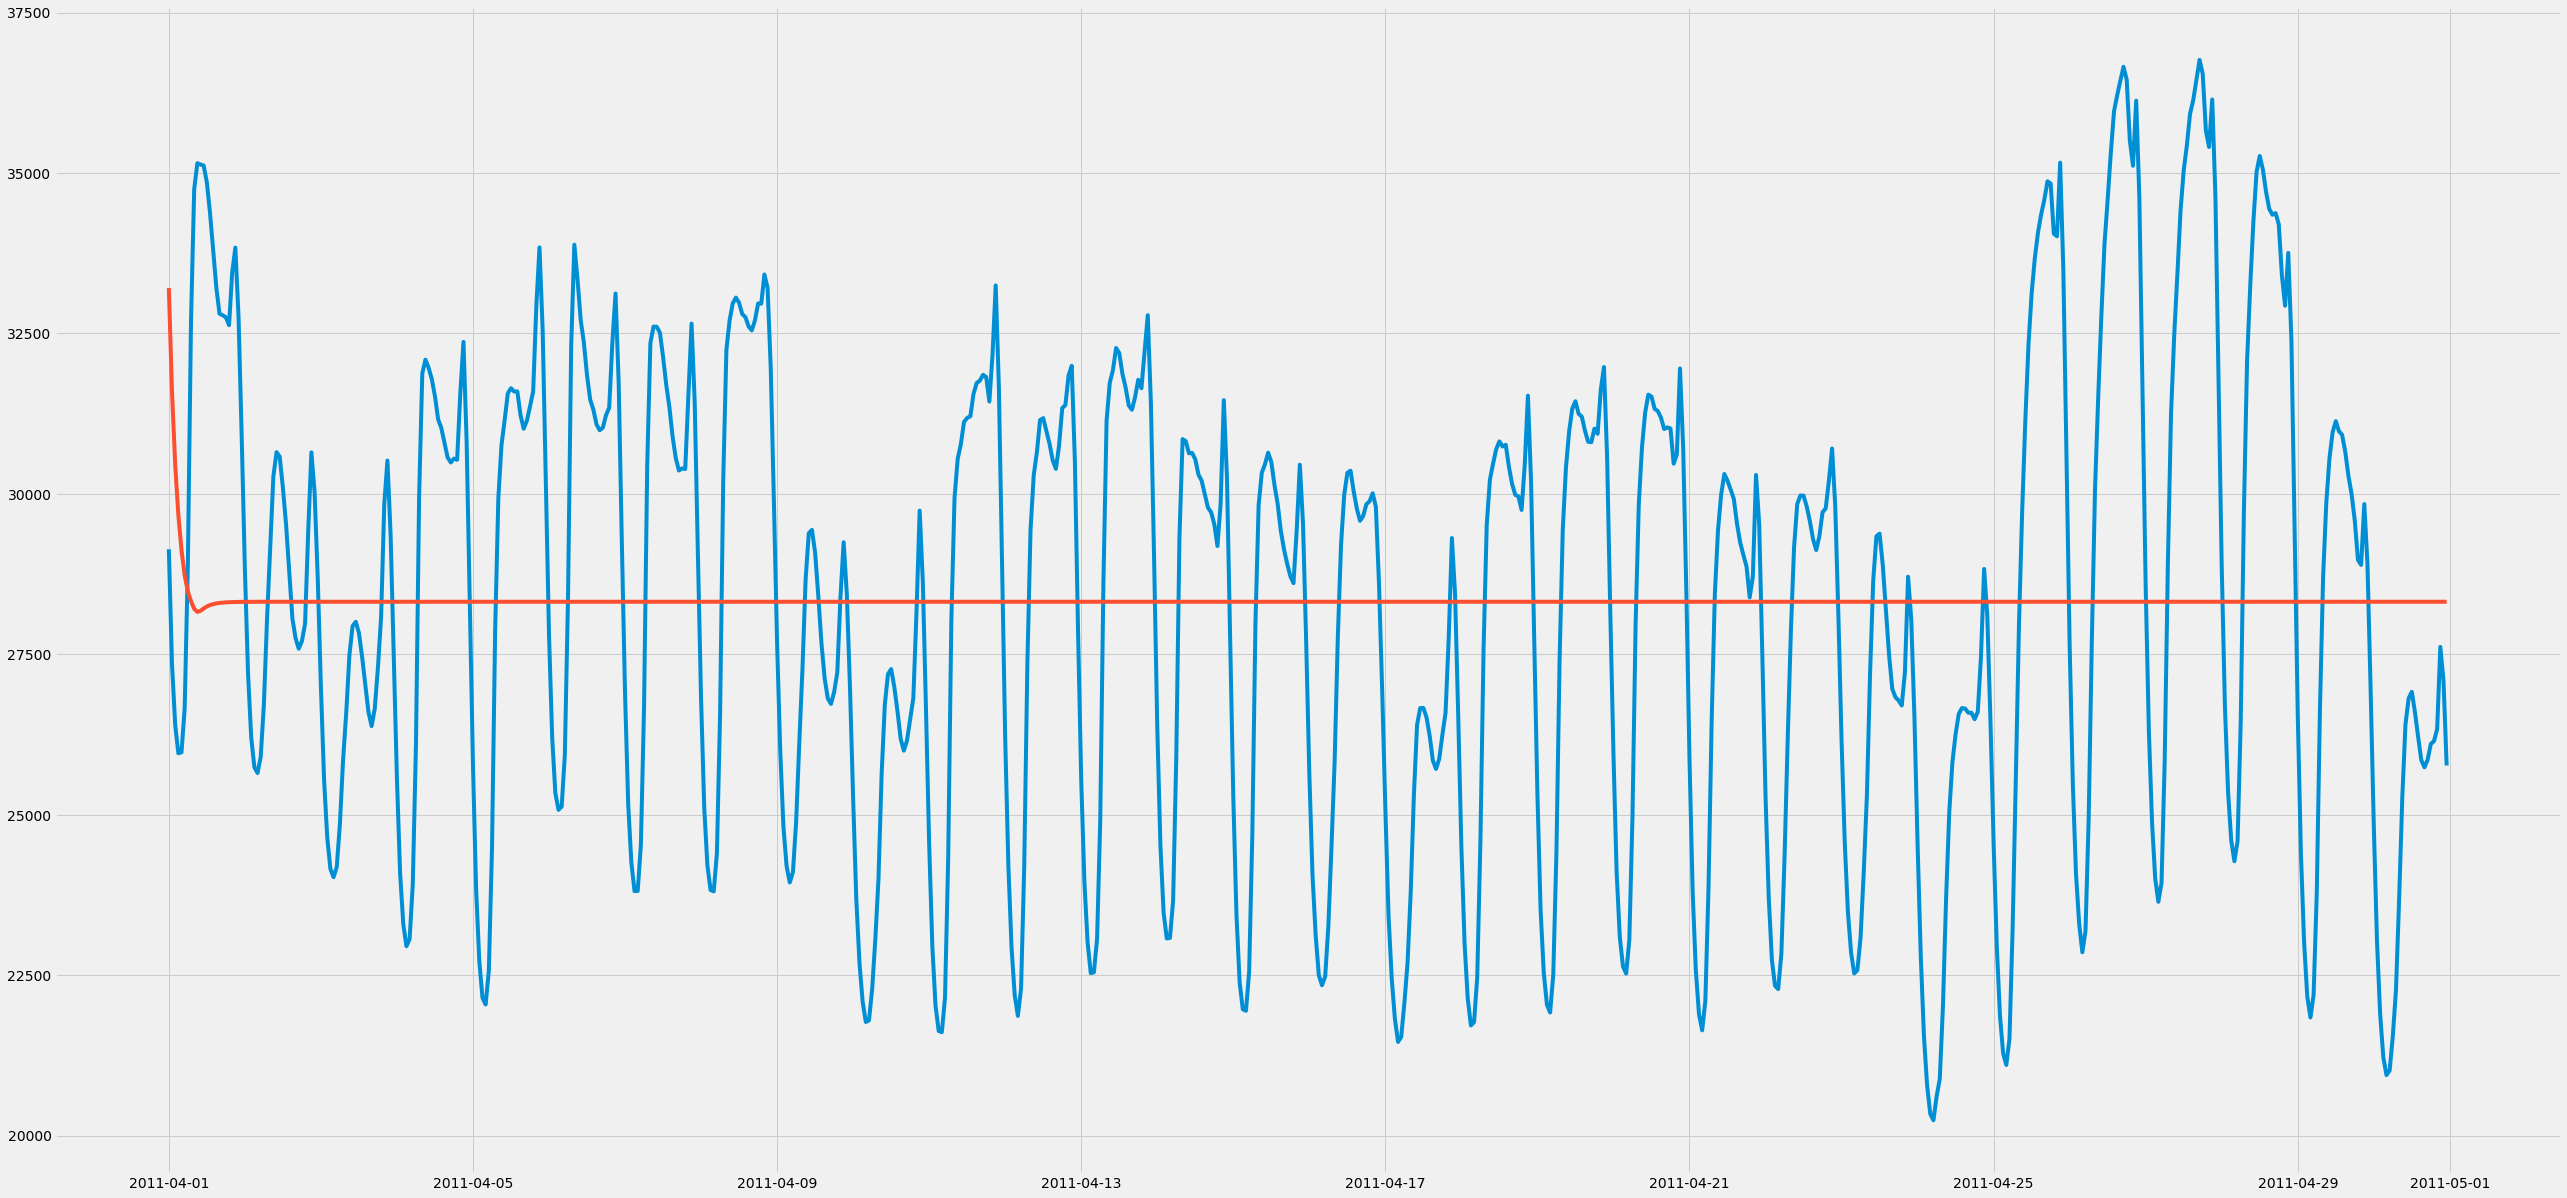

In [63]:
plt.plot(result.Actual)
plt.plot(result.Forecast)
plt.show()